In [ ]:
# Install dependencies (only needed in Colab)
# Uncomment if running in Colab
#!pip install transformers datasets evaluate -q
#!pip install transformers --upgrade

In [1]:
# Setup and imports
import os
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Configuration parameters
CONFIG = {
    "model_name": "dmis-lab/biobert-base-cased-v1.1",
    "max_length": 512,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "epochs": 3,
    "warmup_steps": 500,
    "early_stopping_patience": 3,
    "seed": 42
}

# Set random seeds for reproducibility
import random
import numpy as np
import torch

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
torch.cuda.manual_seed_all(CONFIG["seed"])

In [3]:
file_path = "/content/simple_cleaned_train.csv"
data = pd.read_csv(file_path, index_col=0)
# Display sample data
print("\nSample data:")
display(data.head())
n_labels = len(data['labels'].unique())
print(f"\nNumber of unique labels: {n_labels}")


Sample data:


,medical_specialty,transcription,labels,transcription_cleaned_simple
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0,reason visit high pt inr history patient year ...
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1,preoperative diagnosis acetabular fracture lef...
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1,name procedure selective coronary angiography ...
3,Radiology,"REFERRING DIAGNOSIS: , Motor neuron disease.,P...",2,referring diagnosis motor neuron disease perti...
4,Emergency Room Reports,"CHIEF COMPLAINT: , Dental pain.,HISTORY OF PRE...",0,chief complaint dental pain history present il...



Number of unique labels: 40


In [4]:
# Data preparation
def prepare_datasets(data, test_size=0.2):
    # Train-validation-test split
    train_df, test_df = train_test_split(data, test_size=test_size, random_state=CONFIG["seed"], stratify=data["labels"])

    # Prepare datasets
    train_data = train_df.copy()
    test_data = test_df.copy()

    # Keep only needed columns
    train_data = train_data[['transcription', 'labels']]
    test_data = test_data[['transcription', 'labels']]



    # Rename for compatibility with Hugging Face
    train_data.rename(columns={'labels': 'label', 'transcription_cleaned_simple': 'transcription'}, inplace=True)
    test_data.rename(columns={'labels': 'label', 'transcription_cleaned_simple': 'transcription'}, inplace=True)



    # Convert to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train_data)
    test_dataset = Dataset.from_pandas(test_data)

    return train_dataset, test_dataset, test_df

train_dataset, test_dataset, test_df_original = prepare_datasets(data)

In [ ]:
print(f"\nLoading model: {CONFIG['model_name']}")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG["model_name"],
    num_labels=n_labels
).to(device)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["transcription"],
        padding="max_length",
        truncation=True,
        max_length=CONFIG["max_length"]
    )

# Tokenize and prepare datasets
print("\nTokenizing datasets...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [6]:
# Evaluate pre-trained model (before fine-tuning)
def evaluate_model(model, dataset, batch_size=16):
    model.eval()
    all_preds = []
    all_labels = []

    # Create a DataLoader for batching
    from torch.utils.data import DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }

            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())

    # Return metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, zero_division=1)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "report": report,
        "predictions": all_preds,
        "true_labels": all_labels
    }

print("\nEvaluating pre-trained model (before fine-tuning)...")
pre_train_metrics = evaluate_model(model, tokenized_test_dataset)
print(f"Pre-training accuracy: {pre_train_metrics['accuracy']:.4f}")
print(f"Pre-training F1 score: {pre_train_metrics['f1']:.4f}")
print("Classification report:")
print(pre_train_metrics['report'])


Evaluating pre-trained model (before fine-tuning)...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Pre-training accuracy: 0.0680
Pre-training F1 score: 0.0501
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        13
           1       0.19      0.25      0.22       173
           2       1.00      0.00      0.00        43
           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        34
           5       1.00      0.00      0.00        35
           6       1.00      0.00      0.00        58
           7       1.00      0.00      0.00        62
           8       0.00      0.00      0.00        13
           9       1.00      0.00      0.00        16
          10       1.00      0.00      0.00        42
          11       1.00      0.00      0.00        14
          12       1.00      0.00      0.00         4
          13       1.00      0.00      0.00        27
          14       1.00      0.00      0.00         2
          15       1.00      0.00      0.00         

In [9]:
# Define metrics for evaluation during training
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "f1": f1
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=CONFIG["batch_size"],
    per_device_eval_batch_size=CONFIG["batch_size"],
    learning_rate=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"],
    num_train_epochs=CONFIG["epochs"],
    warmup_steps=CONFIG["warmup_steps"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none",  # Disable wandb/tensorboard if not needed
    seed=CONFIG["seed"],
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG["early_stopping_patience"])]
)

In [ ]:
# Train the model
print("\nFine-tuning the model...")
train_results = trainer.train()

In [ ]:
# Save the fine-tuned model
model_save_path = "./biobert-medical-classifier"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./biobert-medical-classifier


In [13]:
# Final evaluation
print("\nEvaluating fine-tuned model...")
final_metrics = evaluate_model(model, tokenized_test_dataset)
print(f"Final accuracy: {final_metrics['accuracy']:.4f}")
print(f"Final F1 score: {final_metrics['f1']:.4f}")
print("Classification report:")
print(final_metrics['report'])


Evaluating fine-tuned model...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Final accuracy: 0.3715
Final F1 score: 0.2757
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        13
           1       0.45      0.94      0.61       173
           2       0.36      0.49      0.41        43
           3       1.00      0.00      0.00         7
           4       0.35      0.35      0.35        34
           5       0.50      0.06      0.10        35
           6       0.22      0.09      0.12        58
           7       0.36      0.23      0.28        62
           8       1.00      0.00      0.00        13
           9       1.00      0.00      0.00        16
          10       0.00      0.00      0.00        42
          11       1.00      0.00      0.00        14
          12       1.00      0.00      0.00         4
          13       0.18      0.07      0.11        27
          14       1.00      0.00      0.00         2
          15       1.00      0.00      0.00         9
          16

In [ ]:
# Improvement analysis
print("\nModel improvement:")
print(f"Accuracy improvement: {final_metrics['accuracy'] - pre_train_metrics['accuracy']:.4f}")
print(f"F1 score improvement: {final_metrics['f1'] - pre_train_metrics['f1']:.4f}")


Model improvement:
Accuracy improvement: 0.3035
F1 score improvement: 0.2256


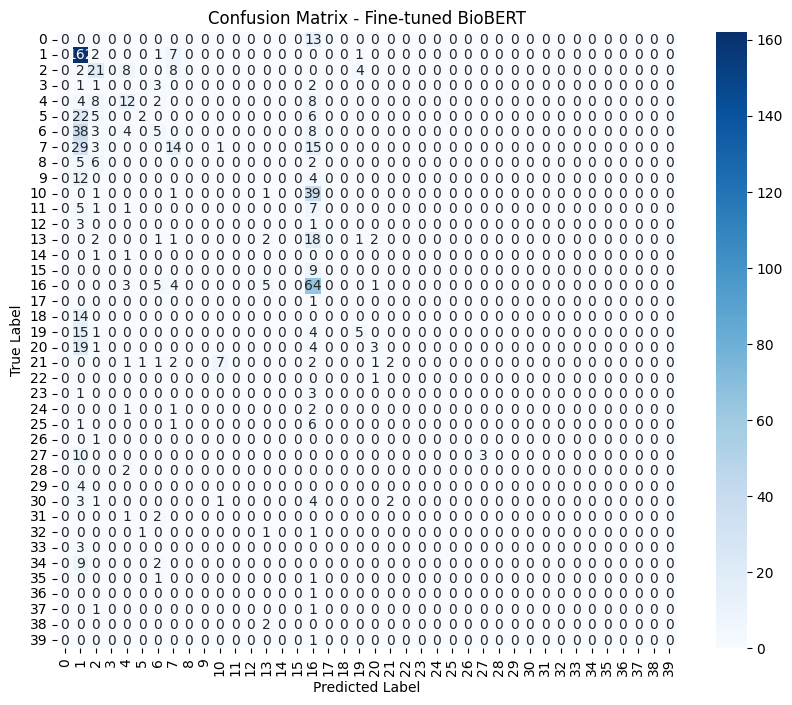


Predicted class for example text: 1


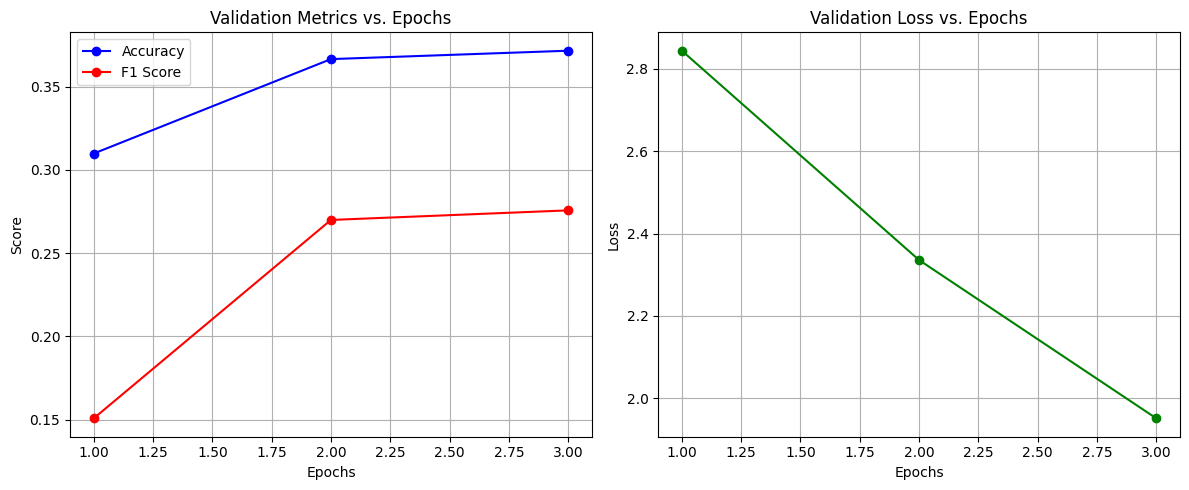

In [15]:
# Visualize results
def plot_confusion_matrix(true_labels, predictions, title="Confusion Matrix"):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(
    final_metrics['true_labels'],
    final_metrics['predictions'],
    title="Confusion Matrix - Fine-tuned BioBERT"
)

# Inference function for new examples
def predict_medical_specialty(text, model=model, tokenizer=tokenizer):
    """Predict medical specialty for a given text"""
    # Tokenize the input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=CONFIG["max_length"]
    ).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    predicted_class = outputs.logits.argmax(dim=1).item()

    # Map back to class name if you have label mapping
    # predicted_label = class_mapping[predicted_class]

    return predicted_class

# Example prediction
example_text = """
PREOPERATIVE DIAGNOSIS:,  Acetabular fracture on the left posterior column/transverse posterior wall variety with an accompanying displaced fracture of the intertrochanteric variety to the left hip.,POSTOPERATIVE DIAGNOSIS:,  Acetabular fracture on the left posterior column/transverse posterior wall variety with an accompanying displaced fracture of the intertrochanteric variety to the left hip.,PROCEDURES:,1.  Osteosynthesis of acetabular fracture on the left, complex variety.,2.  Total hip replacement.,ANESTHESIA: , General.,COMPLICATIONS: , None.,DESCRIPTION OF PROCEDURE: , The patient in the left side up lateral position under adequate general endotracheal anesthesia, the patient's left lower extremity and buttock area were prepped with iodine and alcohol in the usual fashion, draped with sterile towels and drapes so as to create a sterile field.  Kocher Langenbeck variety incision was utilized and carried down through the fascia lata with the split fibers of the gluteus maximus in line.  The femoral insertion of gluteus maximus was tenotomized close to its femoral insertion.  The piriformis and obturator internus tendons and adjacent gemelli were tenotomized close to their femoral insertion, tagged, and retractor was placed in the lesser notch as well as a malleable retractor in the greater notch enabling the exposure of the posterior column.  The major transverse fracture was freed of infolded soft tissue, clotted blood, and lavaged copiously with sterile saline solution and then reduced anatomically with the aid of bone hook in the notch and provisionally stabilized utilizing a tenaculum clamp and definitively stabilized utilizing a 7-hole 3.5 mm reconstruction plate with the montage including two interfragmentary screws.  It should be mentioned that prior to reduction and stabilization of the acetabular fracture its femoral head component was removed from the joint enabling direct visualization of the articular surface.  Once a stable fixation of the reduced fracture of the acetabulum was accomplished, it should be mentioned that in the process of doing this, the posterior wall fragment was hinged on its soft tissue attachments and a capsulotomy was made in the capsule in line with the rent at the level of the posterior wall.  Once this was accomplished, the procedure was turned over to Dr. X and his team, who proceeded with placement of cup and femoral components as well and cup was preceded by placement of a trabecular metal tray for the cup with screw fixation of same.  This will be dictated in separate note.  The patient tolerated the procedure well.  The sciatic nerve was well protected and directly visualized to the level of the notch.
"""

predicted_class = predict_medical_specialty(example_text)
print(f"\nPredicted class for example text: {predicted_class}")

# Performance metrics and charts for training history
train_history = pd.DataFrame(trainer.state.log_history)

# Filter out records without 'eval_accuracy'
eval_records = train_history[train_history.get('eval_accuracy', pd.Series()).notna()]

if not eval_records.empty:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(eval_records['epoch'], eval_records['eval_accuracy'], 'b-o', label='Accuracy')
    plt.plot(eval_records['epoch'], eval_records['eval_f1'], 'r-o', label='F1 Score')
    plt.title('Validation Metrics vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(eval_records['epoch'], eval_records['eval_loss'], 'g-o')
    plt.title('Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()